In [1]:
from TimeSeries_impact import utilities, ts_analysis, impact, plot_functions

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

from imp import reload

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2024-08-02 09:09:30.431111: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-02 09:09:30.432535: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-02 09:09:30.436684: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-02 09:09:30.449017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 09:09:30.469086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

# Create dataset

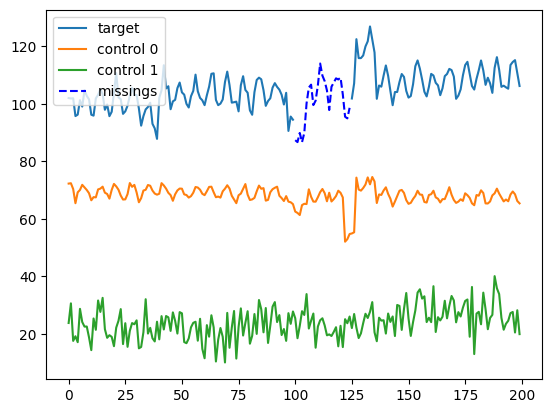

In [2]:
# create fake data where the control has the same underlying seasonal component as target
reload(utilities)
ts = utilities.make_time_serie(200, freq=[7], nbr_rand_event=5) # dict with keys = ['obs', 'control', 'rand_event', 'season', 'base']

# make dataframe
data = pd.DataFrame()
data["target"] = ts["obs"]
for i in range(len(ts["control"])):
    data[f"control {i}"] = ts["control"][i]

# add some missing data in the target time series
without_missing = data["target"].copy()
data["target"][100:125] = np.nan

data.plot()
plt.plot(without_missing[100:125], color="blue", linestyle="dashed", label="missings")
plt.legend()
plt.show()


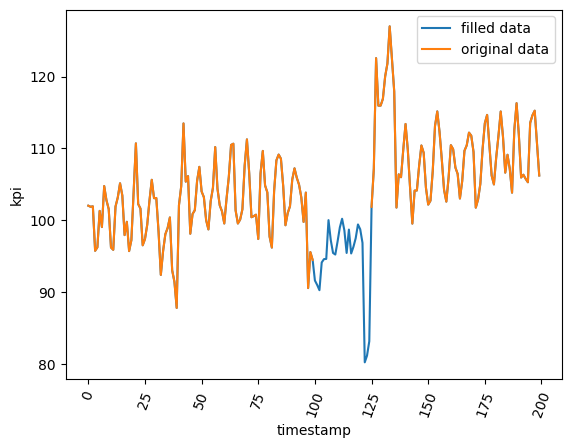

In [3]:
# Fill in data gap

data["target"] = ts_analysis.fill_data(data, inplace=False, plot=True)

# Time series analysis

In [4]:
# create TSA object
reload(ts_analysis)
TSA = ts_analysis.TSA(data)

In [5]:
# plot scaled trend component along with scaled raw data
TSA.plot()

AttributeError: 'TSA' object has no attribute 'df'

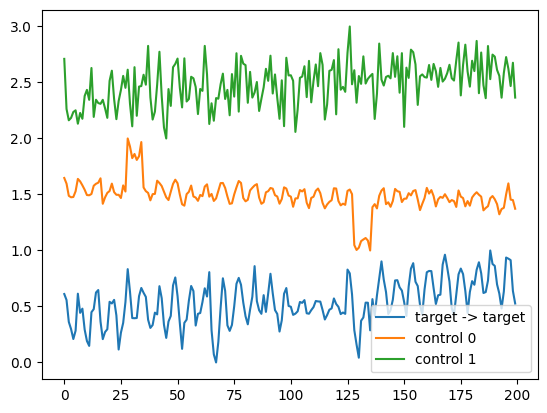

In [ ]:
# check normalized and shifted ts to look for data gaps
TSA.plot_scaled_view()

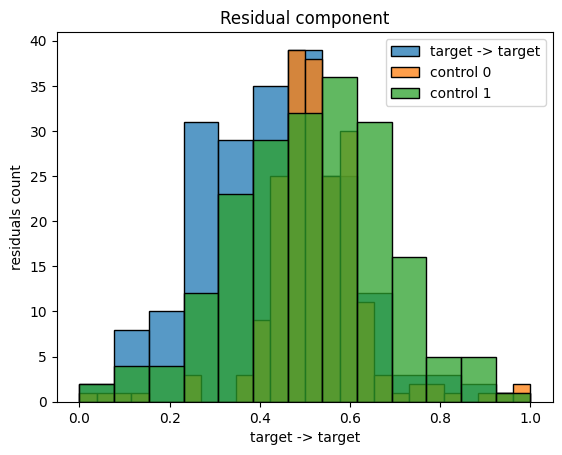

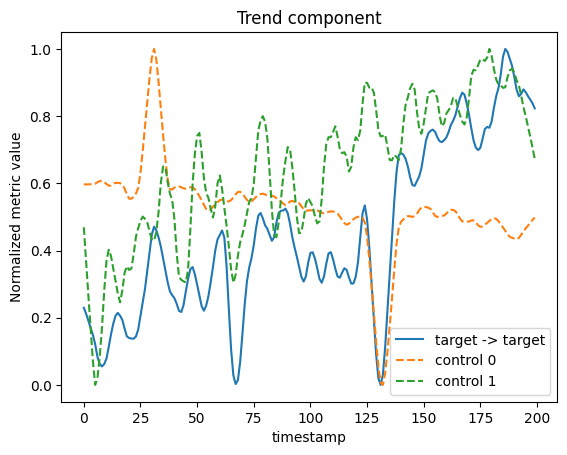

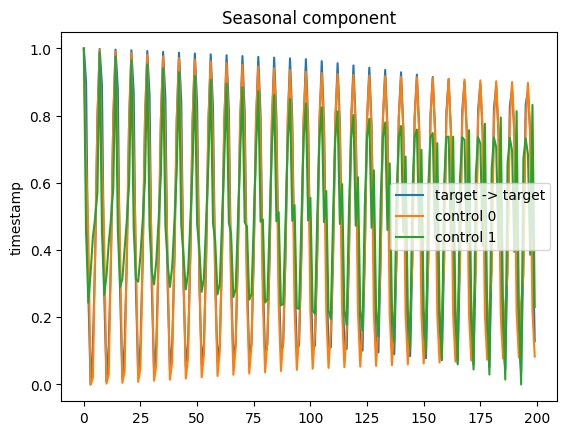

In [ ]:

# plot component from decomposition

TSA.plot()
TSA.plot_component()

In [ ]:
# analyse the similarity of the components
# To use the trend instead of the raw data for the causal impact analysis, the components must be very similar

print()
print("Analysis results")
res_res, res_seas = TSA.analyze()
corr = TSA.correlation()

print()
print("Similarity of residuals")
print(res_res)

print()
print("Similarity of seasonality")
print(res_seas)

print()
print("Correlation of the time series")
print(corr)


Analysis results

Similarity of residuals
                             control 0  control 1
Bhattacharyya Distance        0.076290   0.034858
Kullback-Leibler Divergence   0.413860   0.131372
Hellinger Distance            0.271021   0.185088
Wasserstein Distance          0.104031   0.088236
Kolmogorov test               0.390000   0.265000

Similarity of seasonality
   control 0  control 1
0   0.971969   0.792492

Correlation of the time series
(                  target -> target  control 0  control 1
target -> target          1.000000   0.281550   0.463824
control 0                 0.281550   1.000000  -0.057723
control 1                 0.463824  -0.057723   1.000000,                   target -> target  control 0  control 1
target -> target          1.000000   0.299769   0.473898
control 0                 0.299769   1.000000  -0.007506
control 1                 0.473898  -0.007506   1.000000,                   target -> target  control 0  control 1
target -> target          1.000000

# Simulation and power analysis

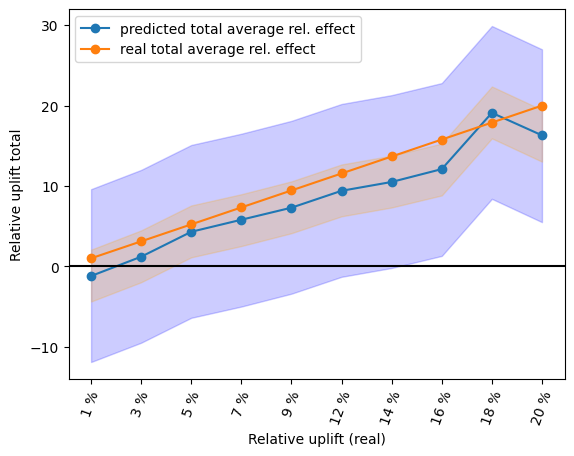

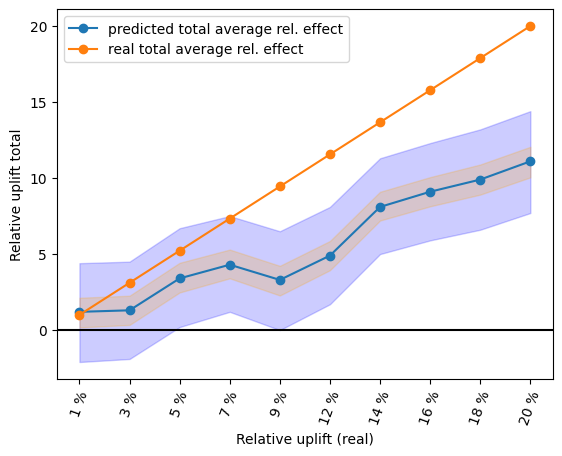

In [6]:
# perform simulation to get "power" of the model

impact_class = impact.SimImpact(data)

# single simulation on raw data
relup = np.linspace(0.01, 0.2, 10)
impact_class.make_sim(relup_list=relup, test_size=14)
fig = impact_class.plot_sim_rel()
display(fig)

# single simulation on trend data
relup = np.linspace(0.01, 0.2, 10)
impact_class.make_sim(relup_list=relup, test_size=14, on_trend=True)
fig = impact_class.plot_sim_rel()
display(fig)


Keys dict_keys(['0.0100', '0.0311', '0.0522', '0.0733', '0.0944', '0.1156', '0.1367', '0.1578', '0.1789', '0.2000'])


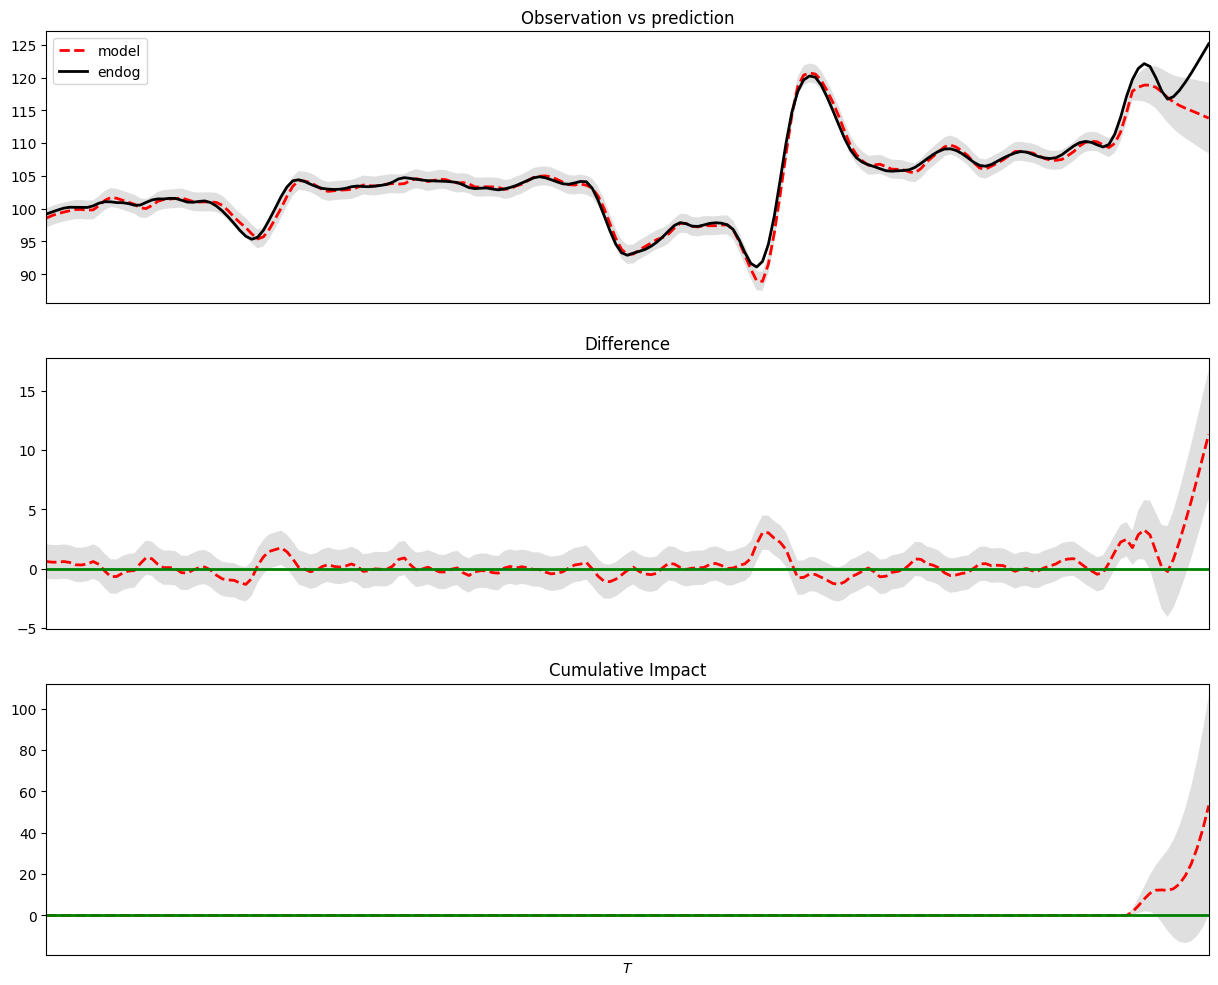

In [7]:
# check single causalimpact results with relup as keys
print("Keys", impact_class.res_sim.keys())
impact_class.res_sim['0.0944'][1].plot()

Starting simulation


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


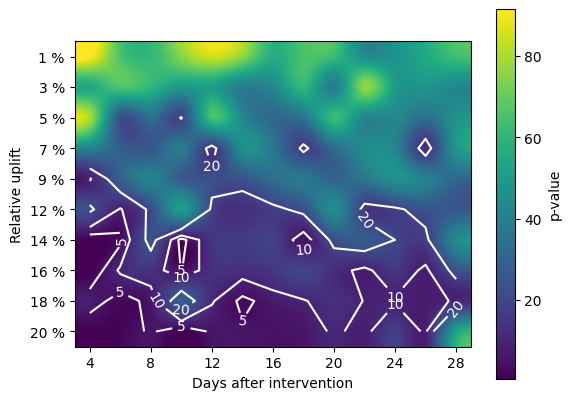

In [8]:
# power analysis by looping over different pre- and post- period lengths

_ = impact_class.power_analyse(relup_list=relup)
fig_power = impact_class.plot_power(alpha=[5,10,20])
display(fig_power)

# Classic causal impact with BSTS

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


2024-08-02 09:11:21.830043: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    127.7              6385.19
Prediction (s.d.)         103.27 (1.21)      5163.41 (60.4)
95% CI                    [101.04, 105.78]   [5052.2, 5288.98]

Absolute effect (s.d.)    24.44 (1.21)       1221.78 (60.4)
95% CI                    [21.92, 26.66]     [1096.21, 1332.99]

Relative effect (s.d.)    23.66% (1.17%)     23.66% (1.17%)
95% CI                    [21.23%, 25.82%]   [21.23%, 25.82%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 127.7. By contrast, in the absence of an
intervention, we would have expected an average response of 103.27.
The 95% interval of this counterfactual prediction is [101.04, 105.78].
Subtracting this prediction f

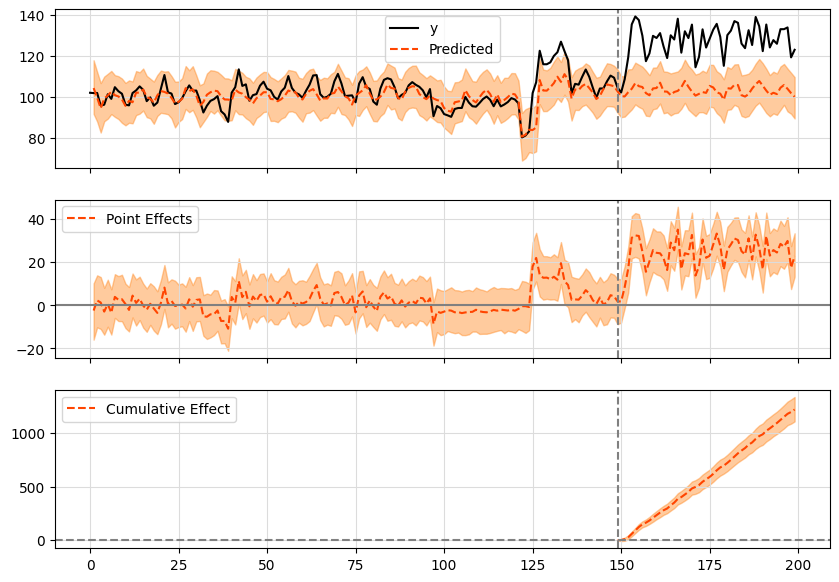

In [9]:
# perform classic causalimpact with tfcausalimpact

# add effect
relup = 0.2
uplift = relup*np.mean(data["target"])
data["target"] = utilities.add_effect(data["target"], uplift, 50)

pre_period = [0, 149]
post_period = [150, 199]

ci = impact.CausalImpact(data, pre_period, post_period, model_args={"period":7})
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()
